## Labor Market Shortages?

Executives are increasingly complaining to the Fed, media, and government that they are not able to find qualified workers. [include examples here, specifically construction] While a tight labor market can result in a situation where not enough workers are available, the labor force participation rate and employment to population ratio both suggest that there are people willing to work. With lots of potential workers still on the sidelines, employers can easily grow their workforce to meet demand. The obvious way to do this is by offering pay above the unemployed workers' reservation wage and providing some training to get them up to speed. It seems, however, that executives are trying a very different technique--getting everyone else to pay to increase the supply of already-trained, lower-wage workers. 

#### Points: 

1) Wages not rising very rapidly in nominal or real terms (real ahe, but also median income (?)).<br>
2) Construction hours not rising very rapidly.<br>
3) Construction is seasonal (average hours worked by month) and very subject to swings in the economy (construction layoffs vs total).<br>
4) Construction will be slowed by Fed rate hikes (higher borrowing costs for builders).

#### Policies that increase the supply of low-wage workers:

1) Training programs that put too much emphasis on the skills that executives demand rather than the skills which most benefit workers. <br>
2) Visas to bring in low-wage workers from overseas in cases where there are plenty of domestic workers with the appropriate skills. <br>

The question faced by executives is therefore whether they 1) plead for government policies that increase the supply of eligible workers, 2) increase the pay offered to lure workers in, or 3) train workers to provide them with the ability to do the job. They seem to be using only method 1 so they must not be desparate.

### Construction industry

The construction industry has pushed that government funds be dedicated to training programs in high schools and colleges. We can examine three measures of the labor market for construction: 1) Job openings per hire, 2) Wages, and 3) hours worked.

#### Technical preliminaries

Python 2.7

In [2]:
import requests
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import config # file which contains API keys

%matplotlib inline

#### Request data from BLS

In [9]:
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}   # Request json data
series_dict = {
    'TOT_NFP': 'CES0000000001',  # Total employment
    'CON_NFP': 'CES2000000001',
    'TOT_AHE': 'CES0500000008',  # Average hourly earnings
    'CON_AHE': 'CES2000000008',
    'CON_QU': 'JTS23000000QUR',  # Quits rate
    'TOT_QU': 'JTS00000000QUR',
    'CON_LD': 'JTS23000000LDR',  # Layoffs/Discharges rate
    'TOT_LD': 'JTS00000000LDR',
    'CON_LDU': 'JTU23000000LDR', # Layoffs/Discharges rate NSA
    'TOT_LDU': 'JTU00000000LDR',
    'CON_JO': 'JTS23000000JOL',  # Job openings (level)
    'TOT_JO': 'JTS00000000JOL',
    'CON_JOU': 'JTU23000000JOL', # Job openings (level) NSA
    'TOT_JOU': 'JTU00000000JOL',
    'CON_UN': 'LNU04032231',     # Unemployed persons NSA
    'TOT_UN': 'LNU03000000',
    'CON_HI': 'JTS23000000HIL',  # Hires (level)
    'TOT_HI': 'JTS00000000HIL',
    'CON_HRS': 'CES2000000002',  # Weekly hours
    'CON_HRS_NSA': 'CEU2000000002',  
    'TOT_HRS': 'CES0500000002',
    'TOT_HRS_NSA': 'CEU0500000002',
    'CPI-W': 'CWSR0000SA0',       # CPI for wage earners
#    'U3': 'LNS14000000',          # Unemployment rate
    'LFPR': 'LNS11300000',        # Labor force participation rate
    'EPOP': 'LNS12300000'         # Employment to population ratio
}
inv_map = {v: k for k, v in series_dict.iteritems()}
series_list = series_dict.values()  # Take just the series codes as a list

date_list = [('1980', '1988'),('1989', '1998'), ('1999', '2008'), ('2009', '2017')]
df = pd.DataFrame()

In [10]:
for start, end in date_list:  # BLS API limits requests to ten year periods
    data = json.dumps({"seriesid":series_list, "startyear":start, "endyear":end})
    json_data = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    # Store the relevant information in a dictionary and combine into a pandas dataframe
    d = {}
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        d[seriesId] = pd.DataFrame(series['data'])
        if len(series['data']) > 0:
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[seriesId]['date'] = pd.to_datetime(d[seriesId]['period'] + ' ' + d[seriesId]['year'])
            # Keep only date and series values
            d[seriesId] = d[seriesId].sort_values(by='date')[['date', 'value']].set_index('date')
            # Rename and round
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId]).astype(float)
        else:
            d[seriesId]['date'] = pd.Series()
            d[seriesId]['value'] = pd.Series()
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId])
    df = df.append(pd.concat([d[series_list[x]] for x in range(len(d))], axis=1))

#### Some basic calculations

Calculate annual wage growth rates and the ratio of job openings per hire for both total private sector and constuction employment.

In [11]:
for ind in ['CON', 'TOT']:
    # Annual growth rate of wages:
    df[ind+'_ahe_ch'] = df[ind+'_AHE'].pct_change(12).multiply(100)    
    # Annual job growth rate:
    df[ind+'_nfp_ch'] = df[ind+'_NFP'].pct_change(12).multiply(100)
    # Job openings per hire:
    df[ind+'_joph'] = df[ind+'_JO'].divide(df[ind+'_HI'])
    # Unemployed per job opening
    df[ind+'_unop'] = df[ind+'_UN'].divide(df[ind+'_JOU'])
    # Real wage
    df[ind+'_rw'] = df[ind+'_AHE'].multiply(df['CPI-W'][0]).divide(df['CPI-W'])
# Construction share of total jobs
df['CON_sh'] = df['CON_NFP'].divide(df['TOT_NFP'])

In [12]:
# List of series
df.keys()

Index([u'TOT_HRS', u'CON_LD', u'CON_JO', u'TOT_NFP', u'CPI-W', u'TOT_JO',
       u'TOT_AHE', u'TOT_JOU', u'CON_HRS', u'CON_NFP', u'LFPR', u'CON_AHE',
       u'CON_QU', u'TOT_QU', u'CON_UN', u'CON_LDU', u'EPOP', u'TOT_LDU',
       u'CON_HRS_NSA', u'TOT_LD', u'TOT_HI', u'TOT_HRS_NSA', u'CON_HI',
       u'CON_JOU', u'TOT_UN', u'CON_ahe_ch', u'CON_nfp_ch', u'CON_joph',
       u'CON_unop', u'CON_rw', u'TOT_ahe_ch', u'TOT_nfp_ch', u'TOT_joph',
       u'TOT_unop', u'TOT_rw', u'CON_sh'],
      dtype='object')

#### Save to csv file

In [13]:
df.to_csv('Construction_Labor_Shortage.csv')

#### View the results

Make a few plots in the CEPR format to show how construction jobs compared to total private sector jobs. Also calculate a few ratios to put context on the sector.

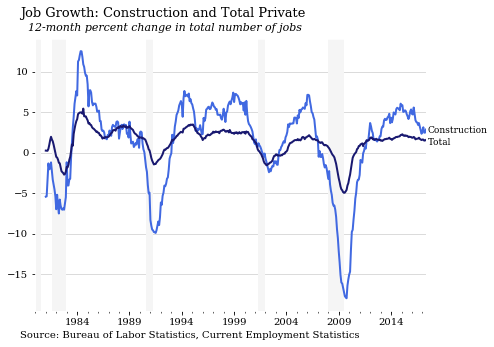

In [14]:
# Job Growth
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

slist = ['CON_nfp_ch', 'TOT_nfp_ch']

df[slist].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 2.5, 'Construction', size=9)
plt.text(570, 1.0, 'Total', size=9)

plt.annotate('Job Growth: Construction and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('12-month percent change in total number of jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')

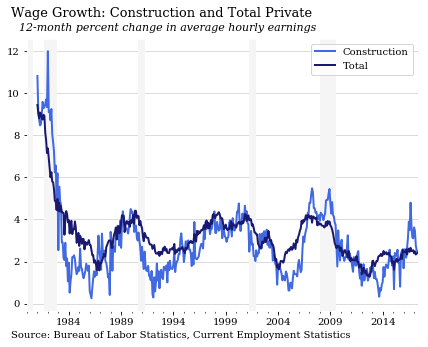

In [15]:
# Wage Growth
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

slist = ['CON_ahe_ch', 'TOT_ahe_ch']

df[slist].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
#plt.text(570, 2.5, 'Construction', size=9)
#plt.text(570, 1.0, 'All Other', size=9)
plt.legend(['Construction', 'Total'])

plt.annotate('Wage Growth: Construction and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('12-month percent change in average hourly earnings', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')

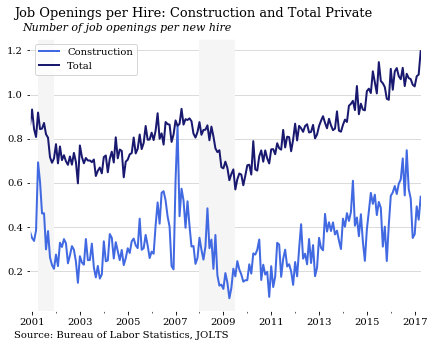

In [17]:
# Job Openings per hire
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

slist = ['CON_joph', 'TOT_joph']

df[slist].dropna().plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
#plt.text(570, 2.5, 'Construction', size=9)
#plt.text(570, 1.0, 'All Other', size=9)
plt.legend(['Construction', 'Total'])

plt.annotate('Job Openings per Hire: Construction and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Number of job openings per new hire', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, JOLTS', xy=(-0.04, -0.1), xycoords='axes fraction')

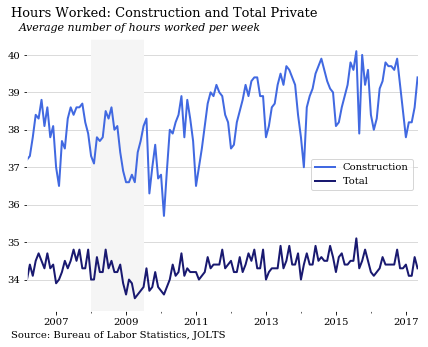

In [18]:
# Job Openings per hire
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

slist = ['CON_HRS_NSA', 'TOT_HRS_NSA']

df[slist].dropna().plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])
#plt.ylim(ymin=0)
plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
#plt.text(570, 2.5, 'Construction', size=9)
#plt.text(570, 1.0, 'All Other', size=9)
plt.legend(['Construction', 'Total'])

plt.annotate('Hours Worked: Construction and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Average number of hours worked per week', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, JOLTS', xy=(-0.04, -0.1), xycoords='axes fraction')

#### Notes: 

*Me to do:*<br>LFPR, epop<br>Layoffs v. total